# Confusion matrix for temporally out-of-sample days

In [1]:
import os
import sys
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
sys.path.append('../')

import core.core_functions as cf
import core.dataset_functions as df
import core.plot_functions as pf

land_masked = True
global_mean = True
dataset_type = 'deseas_historical'
savename_append = ''

2023-04-04 14:49:20.497123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
ERROR 1: PROJ: proj_create_from_database: Open of /jetfs/home/lbrunner/.conda/envs/model_learning/share/proj failed


## Load and prepare test samples (temporally out-of-sample)

In [2]:
samples = cf.get_samples(
    period=slice('2005', '2014'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    verbose=True, 
)

Number of datasets: 47
Loaded dataset 20CR
Loaded dataset ACCESS-CM2
Loaded dataset ACCESS-ESM1-5
Loaded dataset AWI-CM-1-1-MR
Loaded dataset AWI-ESM-1-1-LR
Loaded dataset BCC-CSM2-MR
Loaded dataset BCC-ESM1
Loaded dataset CAMS-CSM1-0
Loaded dataset CESM2-WACCM
Loaded dataset CESM2
Loaded dataset CMCC-CM2-HR4
Loaded dataset CMCC-CM2-SR5
Loaded dataset CMCC-ESM2
Loaded dataset CNRM-CM6-1-HR
Loaded dataset CNRM-CM6-1
Loaded dataset CNRM-ESM2-1
Loaded dataset CanESM5
Loaded dataset EC-Earth3-AerChem
Loaded dataset EC-Earth3-Veg-LR
Loaded dataset EC-Earth3-Veg
Loaded dataset EC-Earth3
Loaded dataset ERA5
Loaded dataset FGOALS-f3-L
Loaded dataset FGOALS-g3
Loaded dataset GFDL-CM4
Loaded dataset GFDL-ESM4
Loaded dataset HadGEM3-GC31-LL
Loaded dataset HadGEM3-GC31-MM
Loaded dataset INM-CM4-8
Loaded dataset INM-CM5-0
Loaded dataset IOSST
Loaded dataset IPSL-CM5A2-INCA
Loaded dataset IPSL-CM6A-LR
Loaded dataset KACE-1-0-G
Loaded dataset KIOST-ESM
Loaded dataset MERRA2
Loaded dataset MIROC-ES2L


In [3]:
XX = samples.transpose('sample', 'lat', 'lon').values
XX = XX.reshape(*XX.shape, 1)  # add a color channel
yy = df.get_dataset_ids(samples['dataset_name'].values)

nan_mask = np.any(np.isnan(XX), axis=0).squeeze()
XX[:, nan_mask, :] = 0  # set nan to constant value

test_generator = ImageDataGenerator() 
testset = test_generator.flow(XX, yy, shuffle=False)

## Load trained classifier

In [4]:
savename =  'multi_class_cnn_{}{}{}.h5'.format(
    dataset_type,
    ('_lm' if land_masked else '') + ('_gm' if global_mean else ''),
    savename_append
)

classifier = load_model(os.path.join('../../data/trained_classifiers', savename))

2023-04-04 14:55:40.220705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test accuracy

In [5]:
classifier.evaluate(testset)

5355/5355 [==============================] - 248s 46ms/step - loss: 0.6584 - acc: 0.8104


[0.6584157347679138, 0.8104056119918823]

## Plot classifier properties

5355/5355 [==============================] - 247s 46ms/step


<AxesSubplot: xlabel='Confidence', ylabel='Accuracy'>

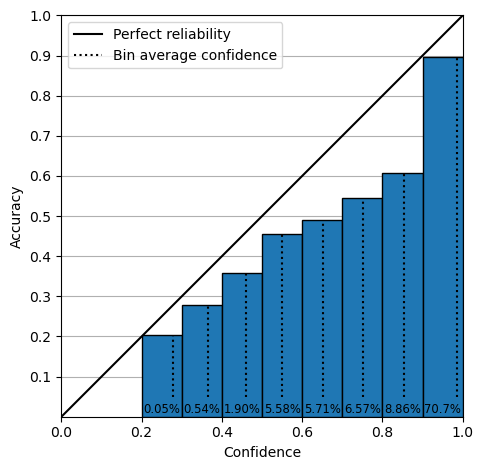

In [6]:
pf.plot_reliability_diagram(classifier, testset)

5355/5355 [==============================] - 248s 46ms/step


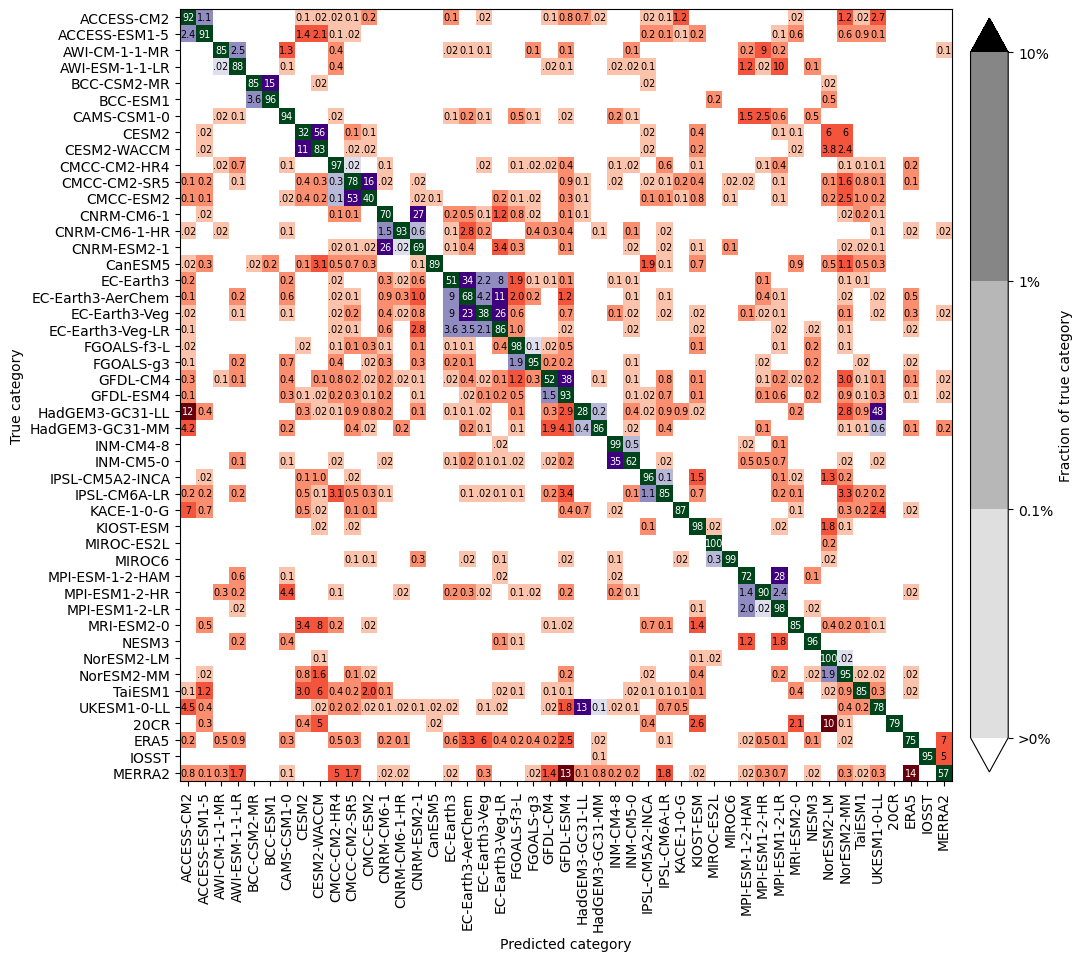

In [7]:
pf.plot_confusion_matrix(yy, classifier.predict(testset))